In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components

* objects and their arrangement are similar to that of the content image
* style, colors, and textures are similar to that of the style image

use a pre-trained VGG19 Net to extract content or style features from a passed in image


In [0]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

%matplotlib inline

In [0]:
# get vgg19 as feature extractor
vgg = models.vgg19(pretrained=True).features

# freeze parameters
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

# Image loader for content and style images

In [0]:
def load_image(img_path, max_size=400, shape=None):
    "image less than 400 pixels in x-y dims"

    if "http" in img_path:
        reponse = requests.get(img_path)
        image = Image.open(BytesIO(reponse.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                                       transforms.Resize(size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

    # discard other channels and add batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [0]:
# folder /content/gdrive/My Drive/14_pyTorch_Training
# load in image files by name and force style image to be the same size as the content image
content  = load_image("/content/gdrive/My Drive/14_pyTorch_Training/IMG_8787.jpg").to(device)

# resize style image
style = load_image("/content/gdrive/My Drive/14_pyTorch_Training/Caspar_David_Friedrich.jpg",
                   shape=content.shape[-2:]).to(device)

In [0]:
# helper function to unnormalize an image

def im_convert(tensor):
    """ Display a tensor as an image """

    image = tensor.cpu().clone().detach()
    image = image.numpy().squeeze()  # removes dimensions with just a 1
    image = image.transpose(1,2,0)  # important for imshow uses matlab convetion
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

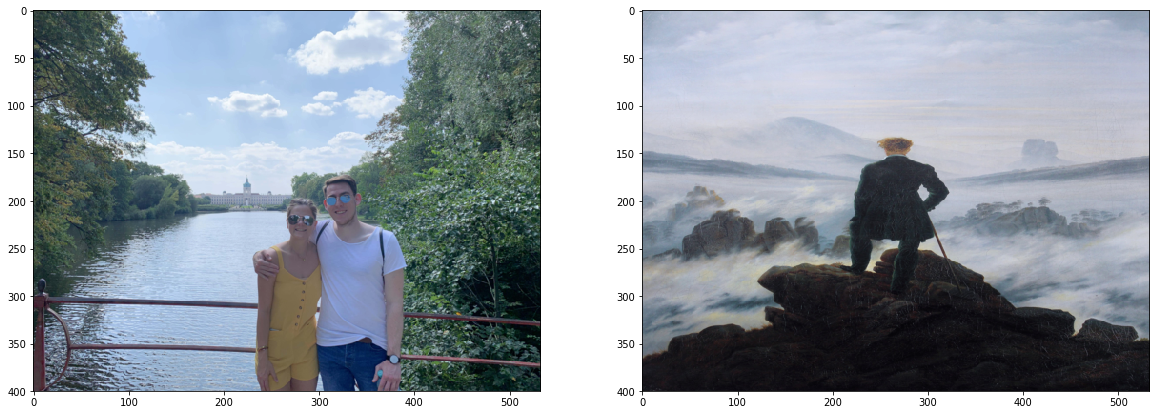

In [0]:
# Display the loaded images

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# VGG19 Adjustements

Get the content and style representation of an image by passing through vgg19 until the desired layer(s) 

In [0]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def get_features(image, model, layers=None):
    """ The images shown were synthesised by matching the content representation
    on layer ‘conv4 2’ and the style representation on layers
    ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’ """
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules holds each module in the model

    # runs through the model, extracts features from specific layers
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


In [0]:
# The output of every convolutional layer is a Tensor with dimensions associated 
# with the batch_size a depth d and some height and width (h, w).

def gram_matrix(tensor):
    batch_size, depth, h, w = tensor.size()

    # reshape so that the features for each channel are multiplied
    tensor = tensor.view(depth, h*w)  # 2D Tensor

    # gram matrix A*A^T
    gram = torch.matmul(tensor,tensor.t())

    return gram

# Extract Features

In [0]:
# get content and style features

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate gram matrixes for each layers of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create the target image and prepr it for change
target = content.clone().requires_grad_(True).to(device)

By weighting earlier layers (conv1_1 and conv2_1) more, you can expect to get larger style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation


Just like in the paper, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want

In [0]:
# weight the style representation at each relevant layer.

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Updating target image and calculating losses

Total loss: 144768992.00


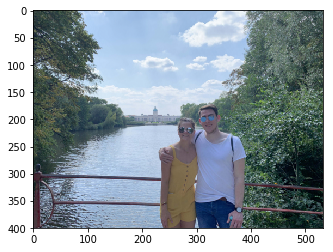

Total loss: 2868840.50


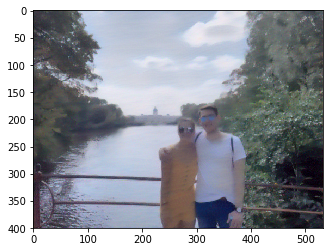

Total loss: 1686202.50


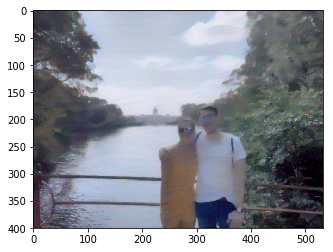

In [0]:
from tqdm import tqdm_notebook as tqdm
# content loss = mean square distance between target and content features at layer conv4_2
# style loss layer_style_loss = for each layer (target_gram - style_gram)


# intermittently display the target image
show_every = 400

optimizer = torch.optim.Adam([target], lr=0.003)
num_epochs = 2000

for epoch in tqdm(range(0,num_epochs)):

    # get features from target image
    target_features = get_features(target, vgg)

    # content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # style loss
    style_loss = 0

    # for each layer's gram matrix loss
    for layer in style_weights:
        # get current target style representation
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        # get desired style representation
        style_gram = style_grams[layer]

        # weighted style loss for the layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss / (d*h*w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # make update step
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images
    if epoch % show_every == 0:
        print('Total loss: {:.2f}'.format(total_loss.item()))
        plt.imshow(im_convert(target))
        plt.show()

# Display before and after style transfer

In [0]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))